In [1]:
import os
import sys

sys.path.append("../src")

In [2]:

import pickle as pkl
import sys
import warnings
from argparse import ArgumentParser
import configparser
from copy import deepcopy
from os import environ
from os.path import join as oj

import numpy as np
import torch
import torch.utils.data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import models
import my_eval
import severson_data
from loss_functions import nll_loss

warnings.filterwarnings("ignore", category=RuntimeWarning)

/home/karino/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt

In [4]:
config = configparser.ConfigParser()
config.read("../sample_config.ini")

['../sample_config.ini']

In [5]:
data_dict = severson_data.load_data(config["DATASET"]["severson_path"])

In [6]:
data_dict.keys(), len(data_dict.keys())

(dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47']),
 84)

In [7]:
data_dict["b1c0"].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [8]:
data_dict["b1c0"]["summary"]["QC"][100], data_dict["b1c0"]["summary"]["QD"][100] 

(1.0753505, 1.0758415)

In [9]:
dat = data_dict["b1c0"]["cycles"]["100"]
print(dat.keys())
# plt.scatter(dat["Qc"], dat["Qd"])
dat["Qc"].max(), dat["Qd"].max()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])


(1.0753505, 1.0758415)

In [12]:
# import pickle
# with open("../additional_data/severson_b1c0_100th-cycle.pkl", 'wb') as f:
#     pickle.dump(dat, f)

In [13]:
# import joblib
# joblib.load("../additional_data/severson_b1c0_100th-cycle.pkl")

In [14]:
start = 10
sequence_length = 100
train_percentage = 0.5
use_cycle_counter=1

In [17]:
# c は充放電条件
# var はデータ
x0, y, c, var = severson_data.get_capacity_input(
    data_dict,
    start_cycle=start,
    stop_cycle=sequence_length,
)

train_idxs, val_idxs, test_idxs = severson_data.get_split(len(x0), seed=42)

if train_percentage != 1:
    train_idxs = train_idxs[:int(train_percentage * len(train_idxs))]

qc_variance_scaler = StandardScaler().fit(var[train_idxs])
var = qc_variance_scaler.transform(var)

augmented_data = np.hstack([c, var])

x = severson_data.scale_x(x0, y)

x = severson_data.remove_outliers(x, y)
old_x = x.copy()

smoothed_x = severson_data.smooth_x(x, y, num_points=20)

In [36]:
np.savez_compressed(
    "data.npz", 
    old_x=old_x, smoothed_x=smoothed_x, augmented_data=augmented_data,y=y,
    train_idx=train_idxs, val_idx=val_idxs, test_idx=test_idxs
)

In [18]:
# (x[[1,2]][:,:100,None][:,:,0]<0.0001)

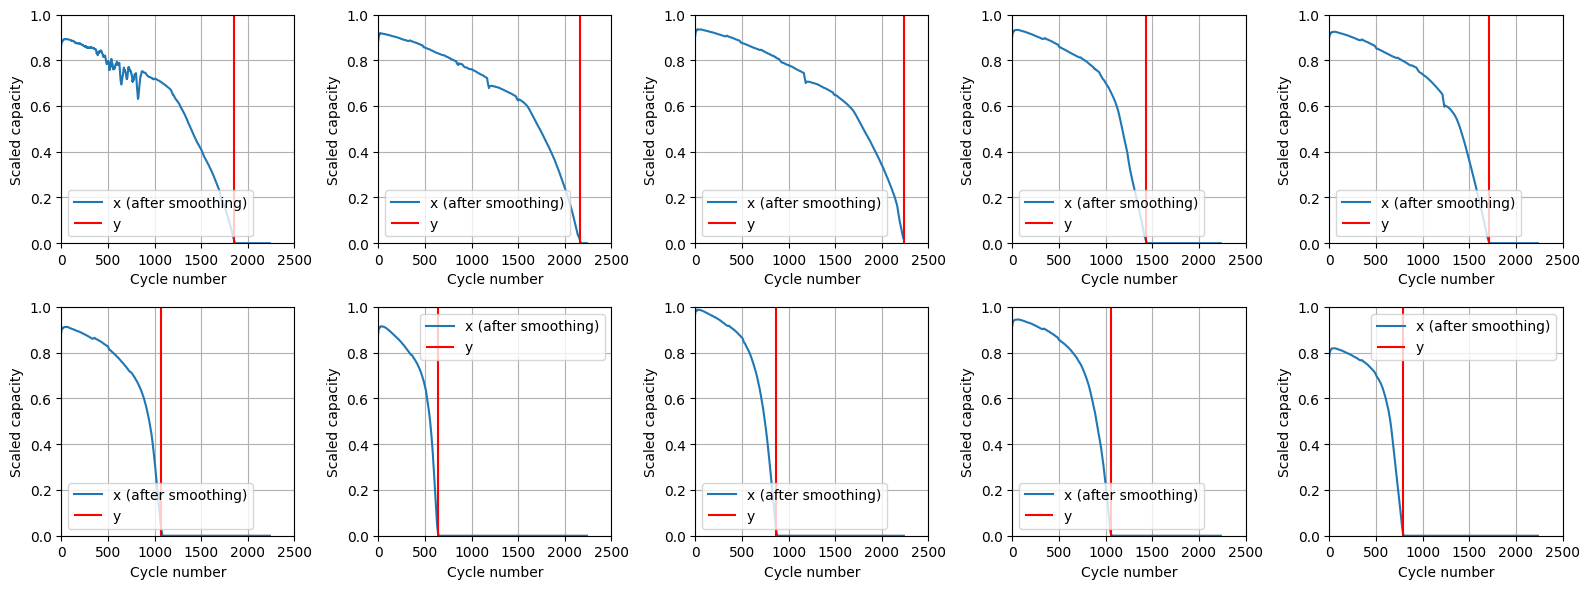

In [19]:
n = 0
plt.figure(figsize=(16,6))
for n in range(10):
    # plt.plot(x0[n], label="x (raw)")
    plt.subplot(2,5,n+1)
    plt.plot(smoothed_x[n], label="x (after smoothing)")
    plt.vlines(x=y[n], ymin=0, ymax=1, color="red",label="y")
    plt.legend()
    plt.xlim(0,2500)
    plt.ylim(0,1)
    plt.xlabel("Cycle number")
    plt.ylabel("Scaled capacity")
    plt.grid()
plt.tight_layout()
plt.show()

In [20]:
train_x, train_y, train_s = severson_data.assemble_dataset(
    smoothed_x[train_idxs],
    y[train_idxs],
    augmented_data[train_idxs],
    seq_len=sequence_length,
    use_cycle_counter=use_cycle_counter,
)

val_x, val_y, val_s = severson_data.assemble_dataset(
    smoothed_x[val_idxs],
    y[val_idxs],
    augmented_data[val_idxs],
    seq_len=sequence_length,
    use_cycle_counter=use_cycle_counter,
)

In [17]:
np.savez_compressed("train", x=train_x, y=train_y, s=train_s)
np.savez_compressed("valid", x=val_x, y=val_y, s=val_s)

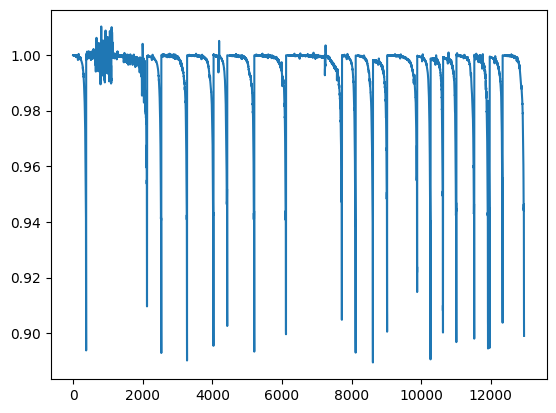

In [27]:
plt.plot(train_y[:,0])